# <span style="color:black; font-weight:bold;">Xenium Multiomics Human Renal Cell Carcinoma Integration Tutorial</span>
+ <span style="color:black; font-weight:bold;">Creator</span>: Bingjie Dai (17516970902@163.com)
+ <span style="color:black; font-weight:bold;">Date of Creation</span>: 10.15.2025
+ <span style="color:black; font-weight:bold;">Date of Last Modification</span>: 10.15.2025
+ <span style="color:black; font-weight:bold;">Download</span>: Xenium Multi-omics Integration data used in the tutorial are available at [RNA.h5ad](https://drive.google.com/open?id=1xBGHWarXybRbxLPwL0FxIIw_84awv93f&usp=drive_fs) and [Protein.h5ad](https://drive.google.com/open?id=1KA-PDXWr5OSYnfTmO1qqpYM-9SBOKUcb&usp=drive_fs)
In this tutorial we apply SpaLP to Xenium Multi-omics Integration (RNA and Protein) of the Human Renal Cell Carcinoma dataset from [10X GENOMICS](https://www.10xgenomics.com/datasets/xenium-protein-ffpe-human-renal-carcinoma)

<span style="color:black; font-weight:bold;">The dataset have:</span>   
+ <span style="color:black; font-weight:bold;">RNA</span>: 465,545 cells and 396 genes   
+ <span style="color:black; font-weight:bold;">Protein</span>: 465,545 cells and 27 proteins    
+ <span style="color:black; font-weight:bold;">After integration Total</span>: 465,545 cells and 423 features

In [3]:
from SpaLP.utils import prepare_inputs, set_seed,create_new_color_dict,Graph
from SpaLP.RandLA import SpatialAutoencoder
import torch
import torch.nn as nn
import torch.optim as optim
import warnings
import scanpy as sc
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import anndata as ad
from tqdm import tqdm
import time

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
set_seed(7)

## <span style="color:black; font-weight:bold;">Loading Xenium Multi-omics Human Renal Cell Carcinoma data</span>

In [6]:
adata1=sc.read_h5ad('/home/dbj/SpaLA/Xeniummultiomics/RNA.h5ad')
adata2=sc.read_h5ad('/home/dbj/SpaLA/Xeniummultiomics/Protein.h5ad')
adata1,adata2

(AnnData object with n_obs × n_vars = 465545 × 396
     obs: 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'genomic_control_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'nucleus_count', 'segmentation_method', 'TACCO_celltype'
     var: 'gene_name', 'feature_type'
     obsm: 'spatial',
 AnnData object with n_obs × n_vars = 465545 × 27
     obs: 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'genomic_control_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'nucleus_count', 'segmentation_method', 'TACCO_celltype'
     var: 'gene_name', 'feature_type'
     obsm: 'spatial')

## <span style="color:black; font-weight:bold;">Data preprocessing</span>
+ We use [scanpy](https://scanpy.readthedocs.io/en/stable/installation.html) package to preprocess each sample separately and horizontal integration them as standard processed expression matrix.

In [7]:
sc.pp.normalize_total(adata1,inplace=True)
sc.pp.log1p(adata1)
sc.pp.scale(adata1)
adata1.obsm['feat']=adata1.X
sc.pp.normalize_total(adata2,inplace=True)
sc.pp.log1p(adata2)
sc.pp.scale(adata2)
adata2.obsm['feat']=adata2.X

In [8]:
adata=sc.AnnData(np.hstack([adata1.obsm['feat'],adata2.obsm['feat']]))
sc.pp.scale(adata)
adata.var_names = adata1.var_names.tolist() + adata2.var_names.tolist()
rna_len = adata1.var_names.shape[0]
prot_len = adata2.var_names.shape[0]
adata.var['feature_type'] = ['RNA'] * rna_len + ['Protein'] * prot_len
adata.obs_names=adata2.obs_names
adata.obsm['spatial']=adata2.obsm['spatial']
adata.obsm['feat']=adata.X

## <span style="color:black; font-weight:bold;">Compute Spatial Neighbor Graph and build the neighbor index matrix</span>
+ We compute the Spatial Graph using 4 neighbors in Xenium Multi-omics Human Renal Cell Carcinoma Integration dataset. k=4  

In [9]:
k=4
graph = prepare_inputs(adata, k, device)

## <span style="color:black; font-weight:bold;">Define Parameters</span>
+ The hidden layer dimension is 64, the Adam optimizer is used to optimize the model, the learning rate lr is 0.001, and the model is trained for 200 epochs.

In [10]:
in_channels = graph.features.shape[1]
model = SpatialAutoencoder(in_channels, out_channels=64).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [11]:
set_seed(7)
epochs = 200
pbar = tqdm(range(epochs), desc="Training",ncols=200)
for epoch in pbar:
    start_time = time.time()
    model.train()
    optimizer.zero_grad()
    reconstructed,embedding = model(graph.features, graph.neighbor_idx)
    loss = criterion(reconstructed, graph.features)
    loss.backward()
    optimizer.step()
    elapsed = time.time() - start_time
    pbar.set_postfix({"Epoch": epoch,"Loss": f"{loss.item():.4f}"})

Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:28<00:00,  7.12it/s, Epoch=199, Loss=0.9423]


## <span style="color:black; font-weight:bold;">Generate cell embedding and reconstructed gene-protein expression</span>
+ Cell embedding was saved in adata.obsm[<span style="color:red;">'SpaLP'</span>]. Reconstructed gene expression is constructed as adata2 

In [12]:
model.eval()
with torch.no_grad():
    reconstructed,embedding = model(graph.features, graph.neighbor_idx)
    reconstructed = reconstructed.cpu().numpy()
    embedding=embedding.cpu().numpy()

### Cell embedding

In [13]:
adata.obsm['SpaLP']=embedding

### Reconstructed gene-protein expression

In [14]:
adata2=sc.AnnData(reconstructed)
adata2.obs=adata.obs
adata2.var=adata.var
adata2.uns=adata.uns
adata2.obsm=adata.obsm

In [20]:
adata.write_h5ad('/home/dbj/SpaLP/Multi-omics/SpaLP.h5ad')
adata2.write_h5ad('/home/dbj/SpaLP/Multi-omics/Reconstruction.h5ad')

## <span style="color:black; font-weight:bold;">Identify Niches</span>
+ We compute Leiden clustering based on the SpaLP embeddings to identify spatial niches.  
+ Here we recommend using the [rapids_singlecell](https://rapids-singlecell.readthedocs.io/en/latest/) package for Ultra large-scale data, a GPU-version of scanpy 

In [1]:
import scanpy as sc
import cupy as cp
import time
import rapids_singlecell as rsc
import warnings
warnings.filterwarnings("ignore")

/home/dbj/anaconda3/envs/rapids_singlecell/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import rmm
from rmm.allocators.cupy import rmm_cupy_allocator
rmm.reinitialize(
    managed_memory=False,  # Allows oversubscription
    pool_allocator=False,  # default is False
    devices=1,  # GPU device IDs to register. By default registers only GPU 0.
)
cp.cuda.set_allocator(rmm_cupy_allocator)

In [3]:
data_load_start = time.time()

## <span style="color:black; font-weight:bold;">Load the embedding and add it to GPU</span>

In [4]:
adata=sc.read_h5ad('/home/dbj/SpaLP/Multi-omics/SpaLP.h5ad')
adata

AnnData object with n_obs × n_vars = 465545 × 423
    var: 'mean', 'std', 'feature_type'
    obsm: 'SpaLP', 'feat', 'spatial'

In [42]:
rsc.get.anndata_to_GPU(adata)

## <span style="color:black; font-weight:bold;">Niche identified by SpaLP</span> 

In [43]:
rsc.pp.neighbors(adata,use_rep='SpaLP',random_state=2024)

In [44]:
rsc.tl.leiden(adata, resolution=0.6,key_added='SpaLP',random_state=2024)

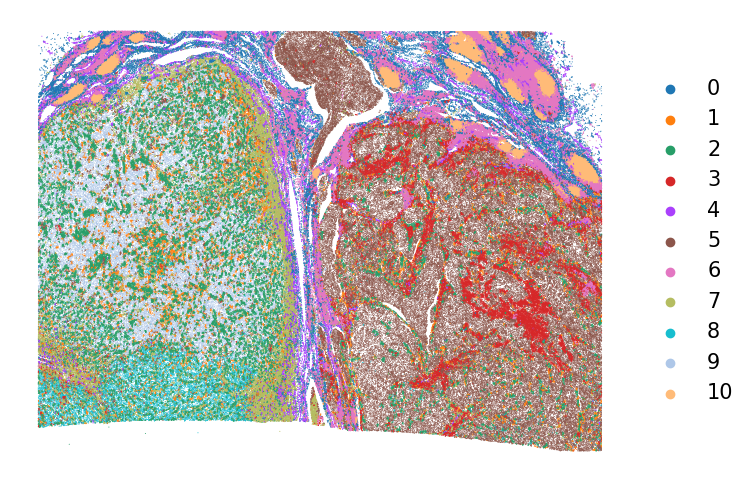

In [94]:
adata.obsm['spatial'][:,1] = -adata.obsm['spatial'][:,1]
import matplotlib.pyplot as plt
import copy
plt.rcParams['figure.figsize'] = (8,6)
plt.rcParams['font.size'] = 15

fig, ax = plt.subplots()
sc.pl.embedding(adata,basis='spatial',color='SpaLP',ax=ax,title='',frameon=False,size=2)

## <span style="color:black; font-weight:bold;">Divide Niches contributed by RNA and protein</span> 
### <span style="color:black; font-weight:bold;">Identify the top 5 markers in each cluster</span> 

In [48]:
adata.raw=adata

In [83]:
sc.tl.rank_genes_groups(adata, groupby="SpaLP", method="wilcoxon")
adata.uns["rank_features_groups"]=adata.uns["rank_genes_groups"]

In [84]:
import pandas as pd
markers = adata.uns['rank_genes_groups']    
groups  = markers['names'].dtype.names         
topn    = 5
cluster_markers = {
    g: [markers['names'][g][i] for i in range(topn)]
    for g in groups
}

### <span style="color:black; font-weight:bold;">Visualize the proportion of proteins and RNA in the top 5 markers of different clusters</span> 

In [85]:
import pandas as pd
feature_type = adata.var['feature_type']
stats = []  

for clust, genes in cluster_markers.items():
    rna_count = sum(feature_type.get(gene) == 'RNA' for gene in genes)
    protein_count = sum(feature_type.get(gene) == 'Protein' for gene in genes)

    stats.append({
        'cluster': clust,
        'RNA': rna_count,
        'Protein': protein_count
    })

df_counts = pd.DataFrame(stats).set_index('cluster')
print(df_counts)

         RNA  Protein
cluster              
0          3        2
1          2        3
2          3        2
3          3        2
4          3        2
5          5        0
6          1        4
7          0        5
8          3        2
9          4        1
10         2        3


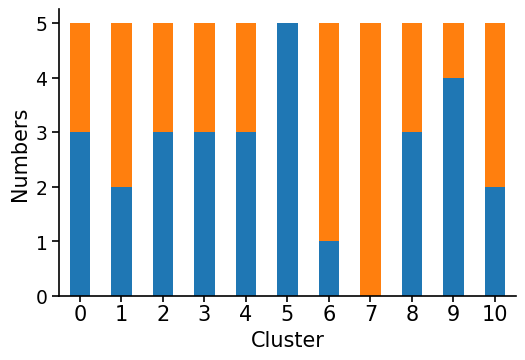

In [86]:
import matplotlib.pyplot as plt
import numpy as np
ax = df_counts.plot(kind='bar', stacked=True, figsize=(5.5,4))
ax.set_ylabel('Number of marker genes')
ax.set_xlabel('Cluster')
ax.set_title('Top 5 marker')
plt.tight_layout()
plt.title('', fontsize=18)       
plt.xlabel('Cluster', fontsize=15)      
plt.ylabel('Numbers', fontsize=15) 
plt.xticks(rotation=45)        
plt.tight_layout()

ax.grid(False)
ax.tick_params(
    axis='x',
    rotation=0,
    labelsize=15,
    length=4,      
    width=1.2,       
    pad=2,
    left=True
)

ax.tick_params(axis='y',
    length=5,       
    width=1.2,       
    labelsize=13.5,
    left=True
)
ax.legend_.remove()

for spine in ax.spines.values():
    spine.set_linewidth(1.2)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#plt.savefig("/home/dbj/SpaLA/Xeniummultiomics/marker_counts15.png", dpi=500, bbox_inches='tight')
plt.show()

In [88]:
ranked_genes_data = adata.uns['rank_genes_groups']
top_5_genes_per_group = {}
all_top_5_genes = []

for group_name in ranked_genes_data['names'].dtype.names:
    genes_for_this_group = ranked_genes_data['names'][group_name][:5].tolist()
    top_5_genes_per_group[group_name] = genes_for_this_group
    all_top_5_genes.extend(genes_for_this_group)

print("Top5marker：")
for group, genes in top_5_genes_per_group.items():
    print(f"  Cluster {group}: {genes}")

unique_top_5_genes = list(set(all_top_5_genes))

Top5marker：
  Cluster 0: ['PTEN', 'TNC', 'CRISPLD2', 'CD31', 'LYVE1']
  Cluster 1: ['HLA-DR', 'CD68', 'FCGR3A', 'CD16', 'FCGR3B']
  Cluster 2: ['alphaSMA', 'Vimentin', 'ACTA2', 'VIM', 'PDGFRB']
  Cluster 3: ['CD3E', 'SLAMF7', 'MZB1', 'CD31', 'TENT5C']
  Cluster 4: ['PTEN', 'VWF', 'CD31', 'PECAM1', 'CD93']
  Cluster 5: ['CXCL6', 'MET', 'KRT8', 'KRT18', 'HAVCR2']
  Cluster 6: ['CD3E', 'CD45', 'CD45RA', 'CD4', 'PTPRC']
  Cluster 7: ['CD8A', 'CD163', 'CD3E', 'PD-1', 'CD45RO']
  Cluster 8: ['PTGDS', 'alphaSMA', 'Vimentin', 'RBP5', 'VIM']
  Cluster 9: ['VIM', 'CXCL6', 'SEMA3C', 'MET', 'Vimentin']
  Cluster 10: ['CD20', 'CD45RA', 'MS4A1', 'CD45', 'CXCR4']


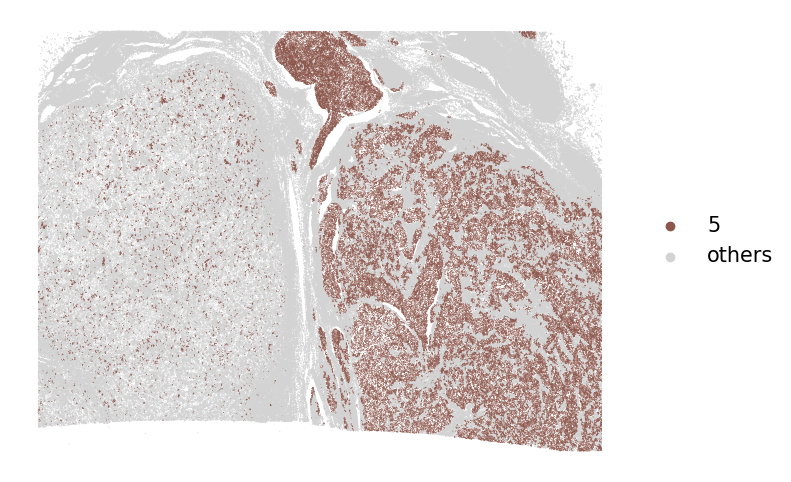

In [96]:
import numpy as np
import pandas as pd

highlight_color = adata.uns['SpaLP_colors'][5]
mask = adata.obs['SpaLP'].astype(str) == '5'
adata.obs['SpaLP_highlight'] = pd.Series(np.where(mask, '5', 'others'), index=adata.obs.index).astype('category')
sc.pl.embedding(adata, basis='spatial', color='SpaLP_highlight',palette={'5': highlight_color, 'others': 'lightgrey'},size=2, frameon=False, title='')

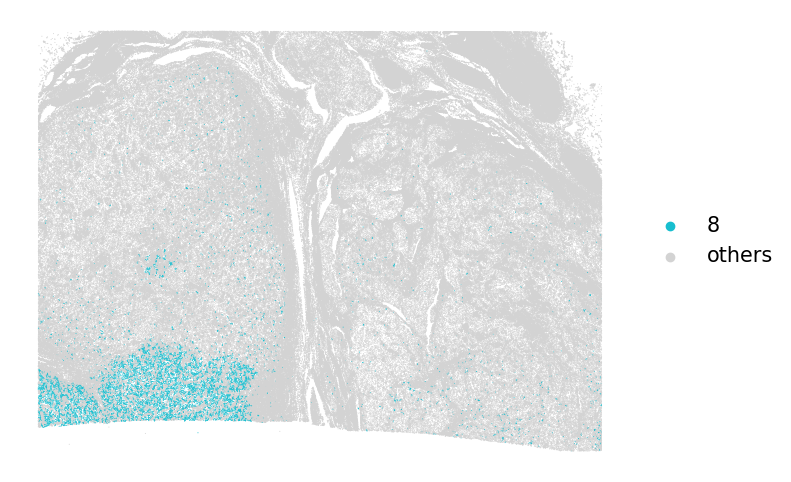

In [98]:
import numpy as np
import pandas as pd

highlight_color = adata.uns['SpaLP_colors'][8]
mask = adata.obs['SpaLP'].astype(str) == '8'
adata.obs['SpaLP_highlight'] = pd.Series(np.where(mask, '8', 'others'), index=adata.obs.index).astype('category')
sc.pl.embedding(adata, basis='spatial', color='SpaLP_highlight',palette={'8': highlight_color, 'others': 'lightgrey'},size=2, frameon=False, title='')

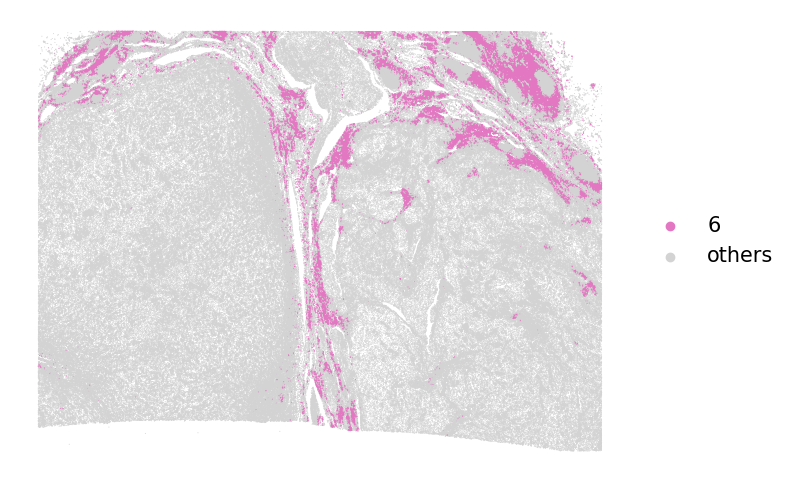

In [99]:
import numpy as np
import pandas as pd
highlight_color = adata.uns['SpaLP_colors'][6]
mask = adata.obs['SpaLP'].astype(str) == '6'
adata.obs['SpaLP_highlight'] = pd.Series(np.where(mask, '6', 'others'), index=adata.obs.index).astype('category')
sc.pl.embedding(adata, basis='spatial', color='SpaLP_highlight',palette={'6': highlight_color, 'others': 'lightgrey'},size=2, frameon=False, title='')

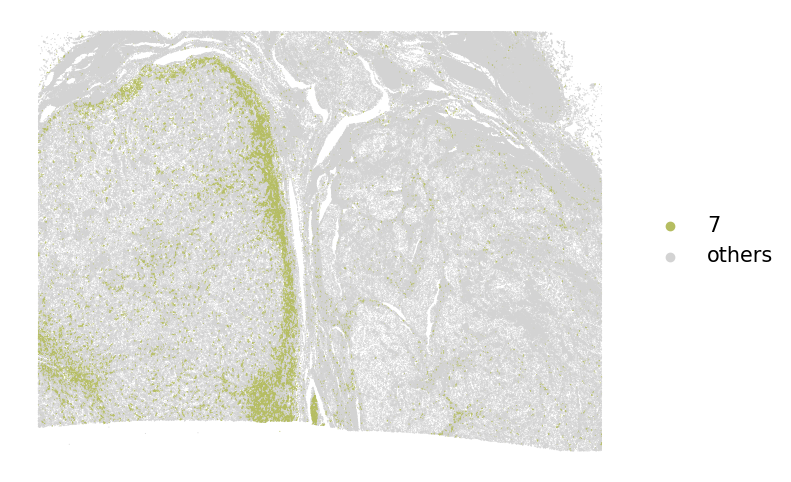

In [100]:
import numpy as np
import pandas as pd
highlight_color = adata.uns['SpaLP_colors'][7]
mask = adata.obs['SpaLP'].astype(str) == '7'
adata.obs['SpaLP_highlight'] = pd.Series(np.where(mask, '7', 'others'), index=adata.obs.index).astype('category')
sc.pl.embedding(adata, basis='spatial', color='SpaLP_highlight',palette={'7': highlight_color, 'others': 'lightgrey'},size=2, frameon=False, title='')

### <span style="color:black; font-weight:bold;">Spatial mapping of protein（CD45RA,CD8A） and gene(CXCL6,PTGDS) expression</span>

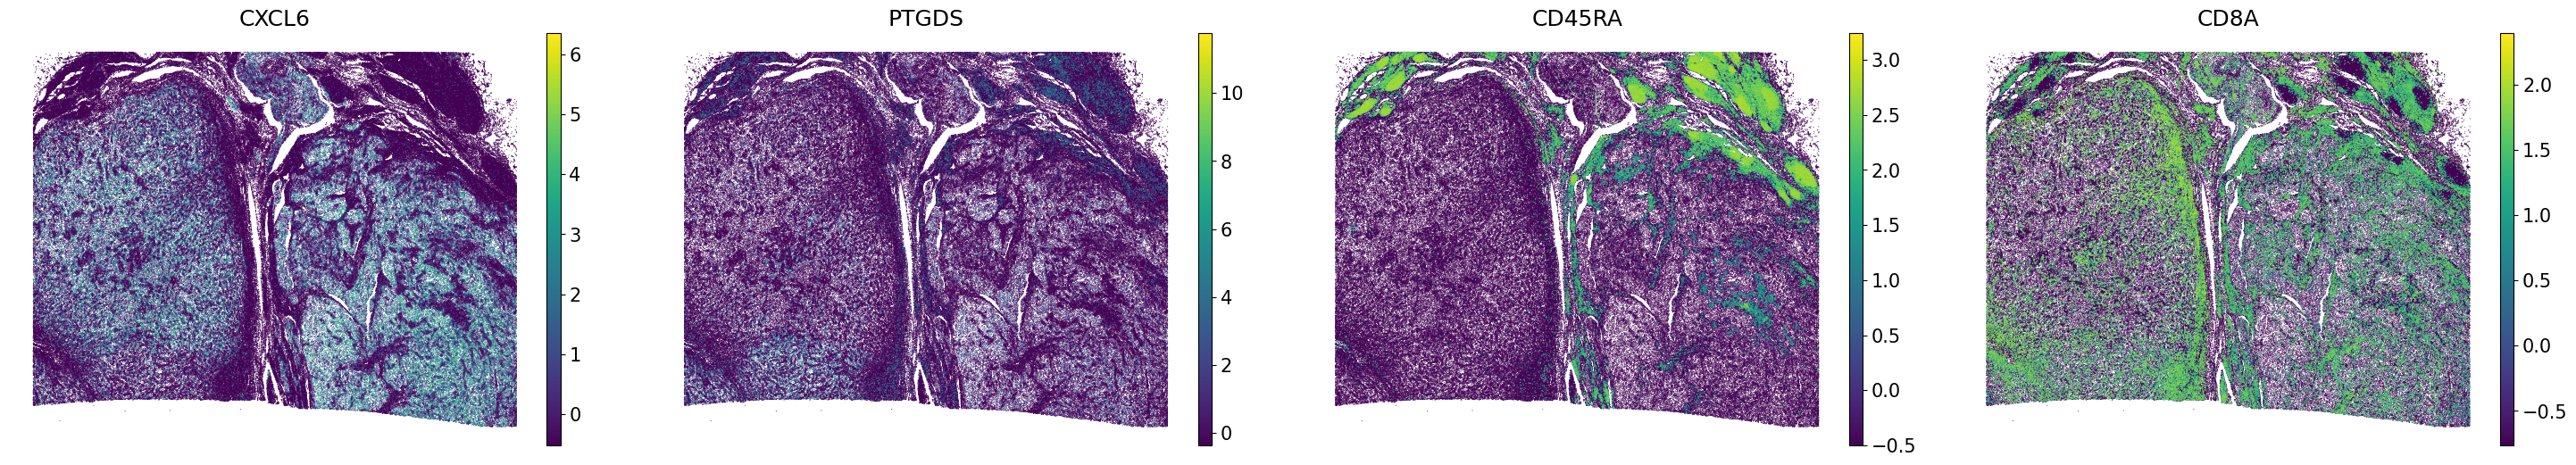

In [107]:
import matplotlib.pyplot as plt
import copy
plt.rcParams['figure.figsize'] = (8,6)
plt.rcParams['font.size'] = 15

sc.pl.embedding(adata, basis='spatial',color=['CXCL6','PTGDS','CD45RA','CD8A'],ncols=4,frameon=False, size=2)